In [92]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate 
from scipy import optimize

# Read data

In [93]:
%run profile_read_py.py

In [94]:
arquivo = '/Volumes/GoogleDrive/My Drive/Estudos/IC/Henrique/Programs/RMlicelPython/RM1183023.324' #30 agosto 2011

read = profile_read(arquivo)
phy  = read[1]

df = pd.DataFrame(phy)

# Aqui é um jeito provisório de fazer o header

lista = []
for i in range(len(read[0]['ch']['active'])):
    wlen = str(read[0]['ch']['wlen'][i])
    pol = str(read[0]['ch']['pol'][i])
    photon = read[0]['ch']['photons'][i]
    an = 'analog' if photon == 0 else 'photon'
    tr = read[0]['ch']['tr'][i]
    lista.append(wlen + ' ' + pol + ' ' + an + ' ' + tr[-1])

###############################################


df.columns = lista
alt = 7.5*(np.array(df.index) + 1)

df['alt'] = alt
s355 = df['355 o analog 0']

In [130]:
df = df.set_index('alt')
df

,355 o analog 0,355 o photon 0,387 o analog 1,387 o photon 1,408 o photon 2
alt,,,,,
7.5,1.610514,135.066667,2.006006,78.700000,2.833333
15.0,1.610107,132.966667,2.006917,66.466667,2.233333
22.5,1.607259,131.233333,2.006453,62.566667,1.433333
30.0,1.609294,130.533333,2.006340,62.700000,1.566667
37.5,1.608073,125.733333,2.005892,55.833333,1.233333
...,...,...,...,...,...
29970.0,1.615804,0.000000,2.010620,0.000000,0.000000
29977.5,1.618856,0.000000,2.010539,0.033333,0.000000
29985.0,1.614583,0.000000,2.009847,0.000000,0.000000


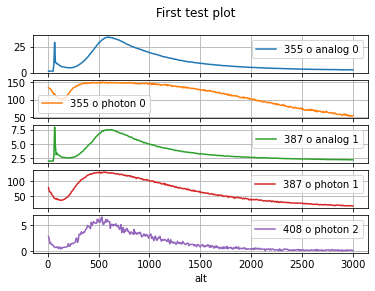

In [131]:
plot = df[:3000].plot(grid=True, subplots=True, title='First test plot')

# Applying corrections to signal data

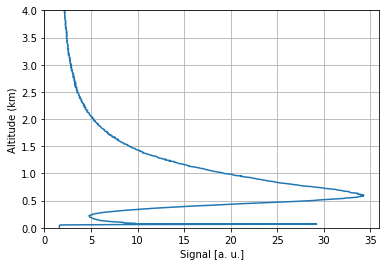

In [135]:
plt.plot(s355, alt*1e-3)
plt.grid(True)
plt.ylabel('Altitude (km)')
plt.xlabel('Signal [a. u.]')
plt.ylim(0, 4)
plt.savefig('fig1', dpi=200)

## Picture for $log(P r^2)$

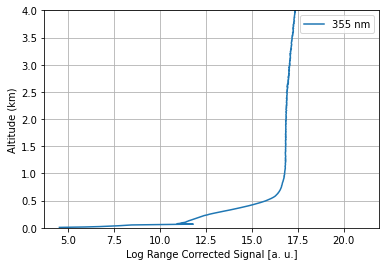

In [137]:
plt.plot(np.log(s355*alt*alt), alt*1e-3)
plt.grid(True)
plt.legend(['355 nm'])
plt.ylabel('Altitude (km)')
plt.xlabel('Log Range Corrected Signal [a. u.]')
plt.ylim(0, 4)
plt.savefig('fig3', dpi=200)

# Read temperature and pressure data

In [98]:
z = alt
Pair = read[0]['P0']*np.exp(-(z-100)/8e3)    # H aproximadamente 8km
Tair = read[0]['T0'] - (9.8*1e-3)*z    # 6.5 lapse rate

In [99]:
Pair *= 100
Pair

array([102478.07889371, 102382.05071499, 102286.1125205 , ...,
         2416.84123136,   2414.57650446,   2412.31389975])

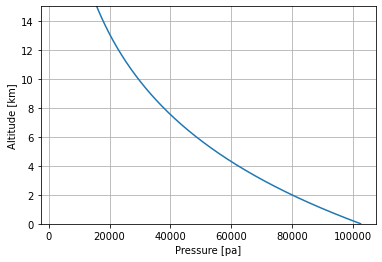

In [100]:
plt.plot(Pair, alt*1e-3)
plt.grid(True)
plt.xlabel('Pressure [pa]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig4', dpi=200)

In [101]:
Tair = read[0]['T0']+273.15 -0.006666666666668182*alt[:int(12000/7.5)]
Tair_p = Tair[-1]*np.ones(len(alt[int(12000/7.5):]))
Tair = np.concatenate((Tair, Tair_p), axis=0)

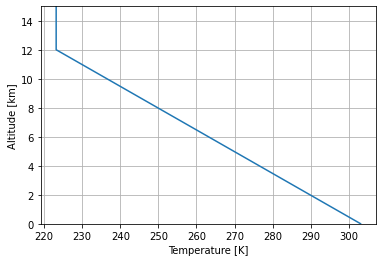

In [102]:
plt.plot(Tair, alt*1e-3)
plt.grid(True)
plt.xlabel('Temperature [K]')
plt.ylabel('Altitude [km]')
plt.ylim(0, 15)
plt.savefig('fig5', dpi=200)

# Molecular Scattering

In [103]:
%run alphabeta.ipynb

In [104]:
lambd = 355*1e-9
co2 = 400


alpha_mol, beta_mol, LR_mol = alphabeta(Pair, Tair, lambd, co2)

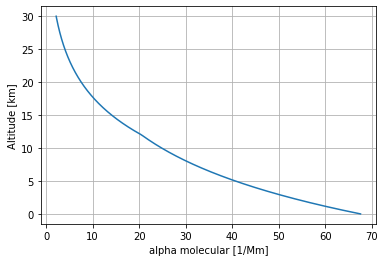

In [105]:
plt.plot(alpha_mol*1e6, alt*1e-3)
plt.grid(True)
plt.xlabel('alpha molecular [1/Mm]')
plt.ylabel('Altitude [km]')
plt.savefig('fig6', dpi=200)

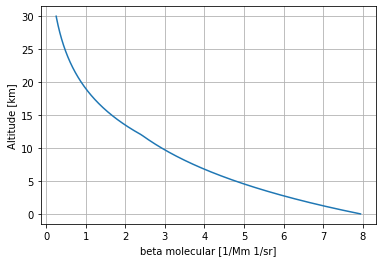

In [106]:
plt.plot(beta_mol*1e6, alt*1e-3)
plt.grid(True)
plt.xlabel('beta molecular [1/Mm 1/sr]')
plt.ylabel('Altitude [km]')
plt.savefig('fig7', dpi=200)

# built the simulated molecular signal

In [107]:
meteo_alt = alt

In [108]:
model = (beta_mol * np.exp(-2*integrate.cumtrapz(alpha_mol, meteo_alt, initial=0))) / meteo_alt**2
bg = int(1e2)

(1e-10, 1000000000000000.0)

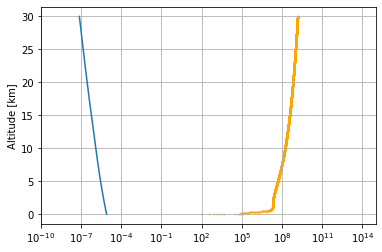

In [116]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((s355)*alt*alt, alt*1e-3, s=0.5, c='orange')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)

In [117]:
alt_max = int(14e3/7.5)
alt_max

1866

Text(0, 0.5, 'Measured signal')

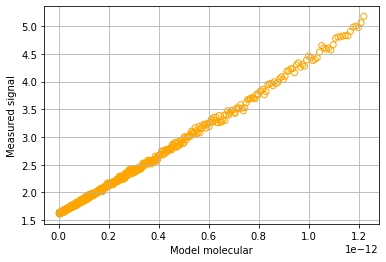

In [120]:
plt.scatter(model[270:alt_max], s355[270:alt_max], facecolors = 'none', edgecolors = 'orange')
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

In [124]:
f = lambda x, a, b: a*x + b

fit = optimize.curve_fit(f, model[270:], s355[270:], p0=(1e13, 116))

a = fit[0][0]
b = fit[0][1]

fit

(array([2.71887702e+12, 1.61119915e+00]),
 array([[ 3.72051706e+18, -1.93976089e+05],
        [-1.93976089e+05,  9.96075183e-08]]))

Text(0, 0.5, 'Measured signal')

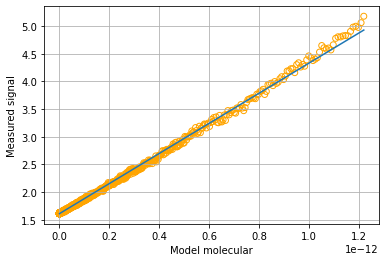

In [125]:
plt.scatter(model[270:], s355[270:], facecolors = 'none', edgecolors = 'orange')
plt.plot(model[270:], f(model[270:], a, b))
plt.grid(True)
plt.xlabel('Model molecular')
plt.ylabel('Measured signal')

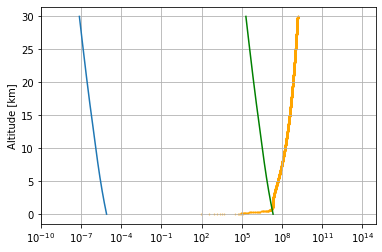

In [126]:
plt.semilogx(model*meteo_alt*meteo_alt, meteo_alt*1e-3)
plt.scatter((s355)*alt*alt, alt*1e-3, s=0.5, c='orange')
plt.semilogx(model*meteo_alt*meteo_alt*a, meteo_alt*1e-3, c='green')
plt.grid(True)
plt.ylabel('Altitude [km]')
plt.xlim(1e-10, 1e15)
plt.savefig('fig8', dpi=200)

In [128]:
%run fernald_new1.ipynb

zref = np.array([6*1e3, 14*1e3])
LR = 28.

z = alt[..., None]
pr = s355.values[..., None]
ref = zref[..., None]
lambd = 355*1e-9
LidarRatio = LR
Pair = Pair[..., None]
Tair = Tair[..., None]


beta_par, alpha_par, LR_par, model_mol, ab_fit = fernald_new1(z,pr,ref,lambd,LidarRatio,Pair,Tair)

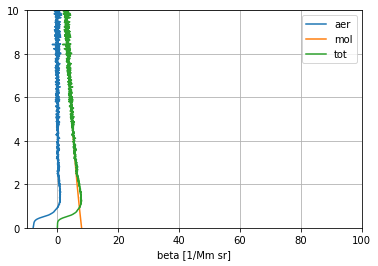

In [129]:
plt.plot((beta_par['aer'])*1e6, alt*1e-3)
plt.plot(beta_par['mol']*1e6, alt*1e-3)
plt.plot(beta_par['tot']*1e6, alt*1e-3)
plt.grid(True)
plt.legend(['aer', 'mol', 'tot'])
plt.xlim(-10, 100)
plt.ylim(0, 10)
plt.xlabel('beta [1/Mm sr]')
plt.savefig('backscatter', dpi=200)